In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [2]:
eeg = pd.read_csv('Stratified_EEG_data.csv')
eeg.head()

,subject ID,Video ID,Attention,Meditation,Raw,Delta,Theta,Alpha 1,Alpha 2,Beta 1,Beta 2,Gamma1,Gamma2,predefined label,Self-defined label,age,ethnicity,gender
0,0,0,56,43,278,301963,90612,33735,23991,27946,45097,33228,8293,0,0,25,Han Chinese,M
1,0,0,40,35,-50,73787,28083,1439,2240,2746,3687,5293,2740,0,0,25,Han Chinese,M
2,0,0,47,48,101,758353,383745,201999,62107,36293,130536,57243,25354,0,0,25,Han Chinese,M
3,0,0,47,57,-5,2012240,129350,61236,17084,11488,62462,49960,33932,0,0,25,Han Chinese,M
4,0,0,44,53,-8,1005145,354328,37102,88881,45307,99603,44790,29749,0,0,25,Han Chinese,M


Put column names in consistent format:

In [3]:
renamed = []
# build new list of column names
for col in list(eeg.columns):
    newval = col.lower().replace(' ', '')
    renamed.append(newval)  

eeg.columns = renamed
eeg.head()

,subjectid,videoid,attention,meditation,raw,delta,theta,alpha1,alpha2,beta1,beta2,gamma1,gamma2,predefinedlabel,self-definedlabel,age,ethnicity,gender
0,0,0,56,43,278,301963,90612,33735,23991,27946,45097,33228,8293,0,0,25,Han Chinese,M
1,0,0,40,35,-50,73787,28083,1439,2240,2746,3687,5293,2740,0,0,25,Han Chinese,M
2,0,0,47,48,101,758353,383745,201999,62107,36293,130536,57243,25354,0,0,25,Han Chinese,M
3,0,0,47,57,-5,2012240,129350,61236,17084,11488,62462,49960,33932,0,0,25,Han Chinese,M
4,0,0,44,53,-8,1005145,354328,37102,88881,45307,99603,44790,29749,0,0,25,Han Chinese,M


In [35]:
# id columns:
idcols = ['subjectid', 'videoid']

# numeric columns:
numcols = ['attention', 'meditation', 'raw', 'delta', 'theta', 'alpha1', 
           'alpha2', 'beta1', 'beta2', 'gamma1', 'gamma2', 'age']
# categorical columns:
catcols = ['ethnicity', 'gender']
# target predictor columns:
targetcols = ['predefinedlabel', 'self-definedlabel']

# set dummies on categorical columns:
catdummies = pd.get_dummies(eeg[catcols])

# convert eeg data to standard spreadsheet format:
finaldata = pd.concat([eeg[idcols], eeg[numcols], catdummies, eeg[targetcols]], axis = 1)

# save dataset:
finaldata.to_csv('eeg_standardspreadsheet.csv')

## Look at distributions of numeric colums:

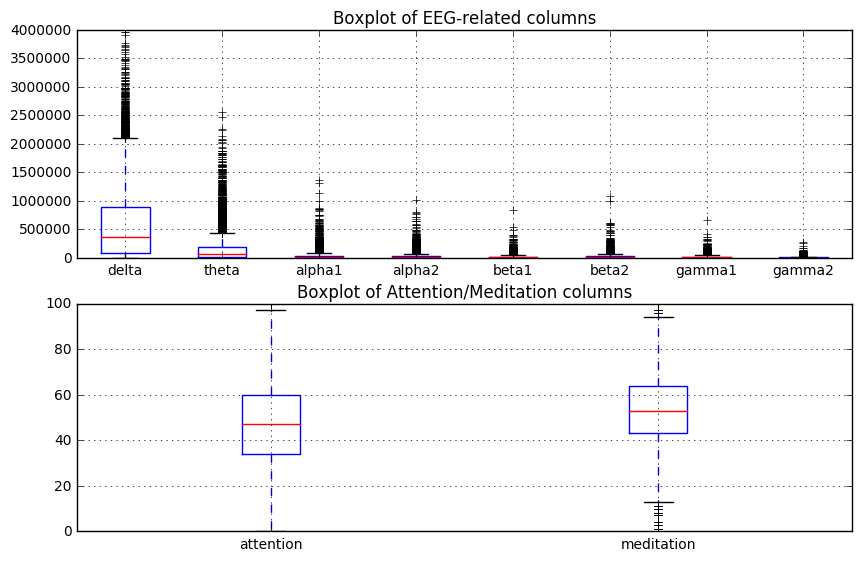

In [36]:
# all numeric columns other than attention, meditation, age:
eegcols = [col for col in numcols if col not in ['attention', 'meditation', 'raw', 'age']]
amcols = ['attention', 'meditation']

fig = plt.figure(figsize = (10, 10))

plt.subplot(311)
finaldata[eegcols].boxplot(return_type = 'axes')
plt.title('Boxplot of EEG-related columns')

plt.subplot(312)
finaldata[amcols].boxplot(return_type = 'axes')
plt.title('Boxplot of Attention/Meditation columns')


Definite problems with skew and different scales to the predictors.

## Transform Numeric columns to normalize & rescale:

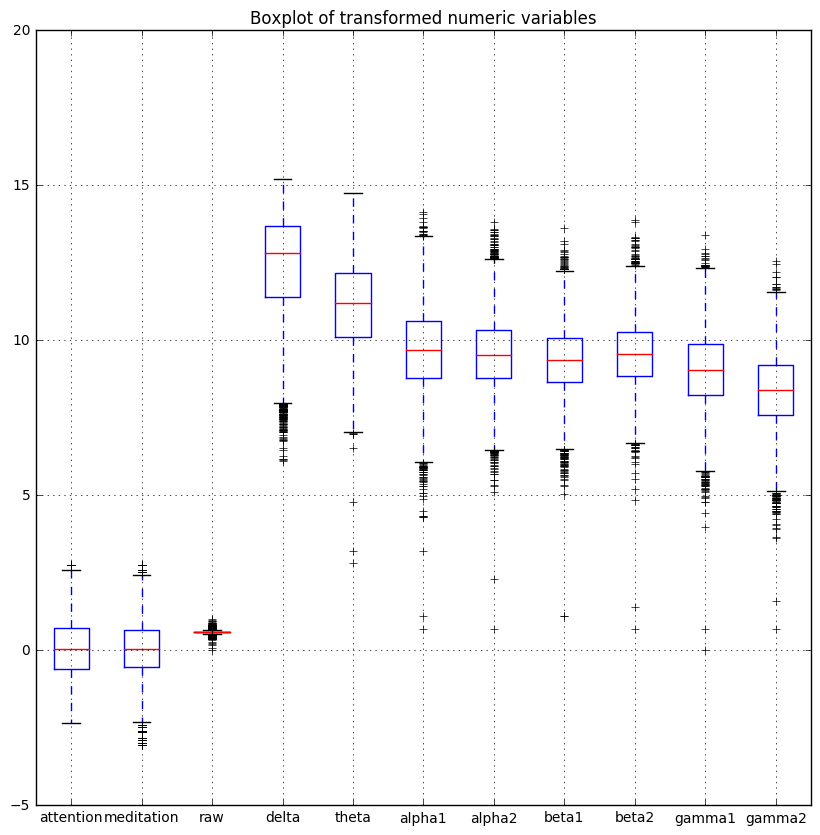

In [37]:
# log transform skewed columns:
eeg_logtransform = finaldata[eegcols].apply(np.log, axis = 1)

# z scores for relatively normal columns:
attention_z = pd.DataFrame(stats.zscore(finaldata[['attention']]))
meditation_z = pd.DataFrame(stats.zscore(finaldata[['meditation']]))

att_med_zscores = pd.concat([attention_z, meditation_z], axis = 1)
att_med_zscores.columns = ['attention', 'meditation']

# min max transform for raw column:
raw_mm = (finaldata[['raw']] - finaldata[['raw']].min()) / (finaldata[['raw']].max() - finaldata[['raw']].min())

# concatenate transformed columns:
transformeddata = pd.concat([att_med_zscores, raw_mm, eeg_logtransform], axis = 1)

fig = plt.figure(figsize = (10, 10))
# display the results:
transformeddata.boxplot(return_type = 'axes')
plt.title('Boxplot of transformed numeric variables')

Still have some issues with the variables being on different scaless and with outliers.

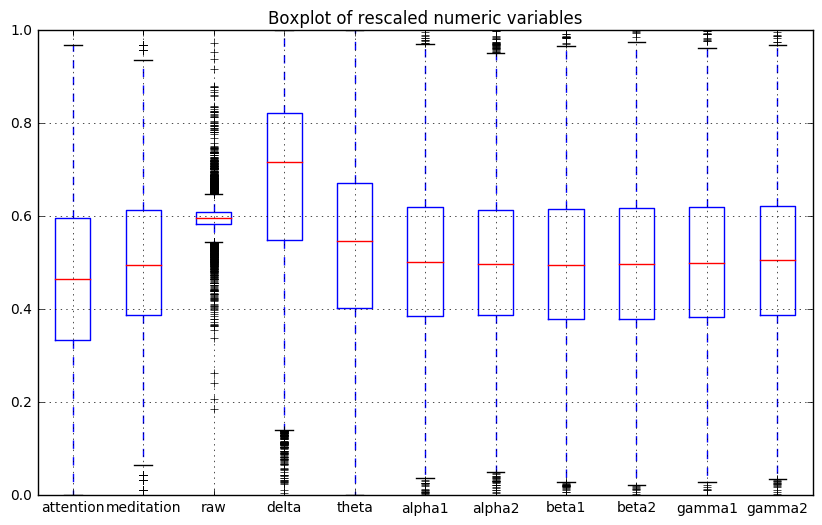

In [65]:
outlierrmcols = eegcols + amcols

# remove observations outside 3 standard deviations from the mean in the eeg columns:
for col in outlierrmcols:
    transformeddata = transformeddata[np.abs(transformeddata[col] - 
                                             transformeddata[col].mean()) <= (3.0 * transformeddata[col].std())]
# scale to a 0-1 interval:
for col in outlierrmcols:
    transformeddata[col] = (transformeddata[col] - transformeddata[col].min()) / \
    (transformeddata[col].max() - transformeddata[col].min())

# display results:  
fig = plt.figure(figsize = (10, 6))
transformeddata.boxplot(return_type = 'axes')
plt.title('Boxplot of rescaled numeric variables')

In [42]:
transformeddata.corr()

,attention,meditation,raw,delta,theta,alpha1,alpha2,beta1,beta2,gamma1,gamma2
attention,1.000000,0.162521,-0.007704,-0.342053,-0.380070,-0.255664,-0.209190,-0.121509,0.041796,-0.062498,0.025792
meditation,0.162521,1.000000,0.019423,-0.178204,-0.247623,0.066737,0.069981,-0.065866,-0.138154,-0.122541,-0.090268
raw,-0.007704,0.019423,1.000000,-0.011775,-0.019165,-0.021684,-0.008135,-0.015419,-0.024205,-0.022023,-0.014765
delta,-0.342053,-0.178204,-0.011775,1.000000,0.726374,0.551403,0.480768,0.412873,0.417159,0.425558,0.246699
theta,-0.380070,-0.247623,-0.019165,0.726374,1.000000,0.671081,0.619734,0.614309,0.571417,0.544673,0.431669
alpha1,-0.255664,0.066737,-0.021684,0.551403,0.671081,1.000000,0.615213,0.599691,0.560806,0.517688,0.422549
alpha2,-0.209190,0.069981,-0.008135,0.480768,0.619734,0.615213,1.000000,0.637018,0.621514,0.561822,0.450328
beta1,-0.121509,-0.065866,-0.015419,0.412873,0.614309,0.599691,0.637018,1.000000,0.638028,0.595669,0.600185
beta2,0.041796,-0.138154,-0.024205,0.417159,0.571417,0.560806,0.621514,0.638028,1.000000,0.778623,0.664694
gamma1,-0.062498,-0.122541,-0.022023,0.425558,0.544673,0.517688,0.561822,0.595669,0.778623,1.000000,0.734346


Now make the final dataframe for analysis

In [64]:
# make sure we only keep the transformed data indices in the final dataset:
finaldata = finaldata.ix[transformeddata.index.values, :]

# reset values in the 'finaldata' set based on the transformed numerics:
finaldata[transformeddata.columns] = transformeddata

11029

## New section - group data at subjectid + videoid level before analysis:

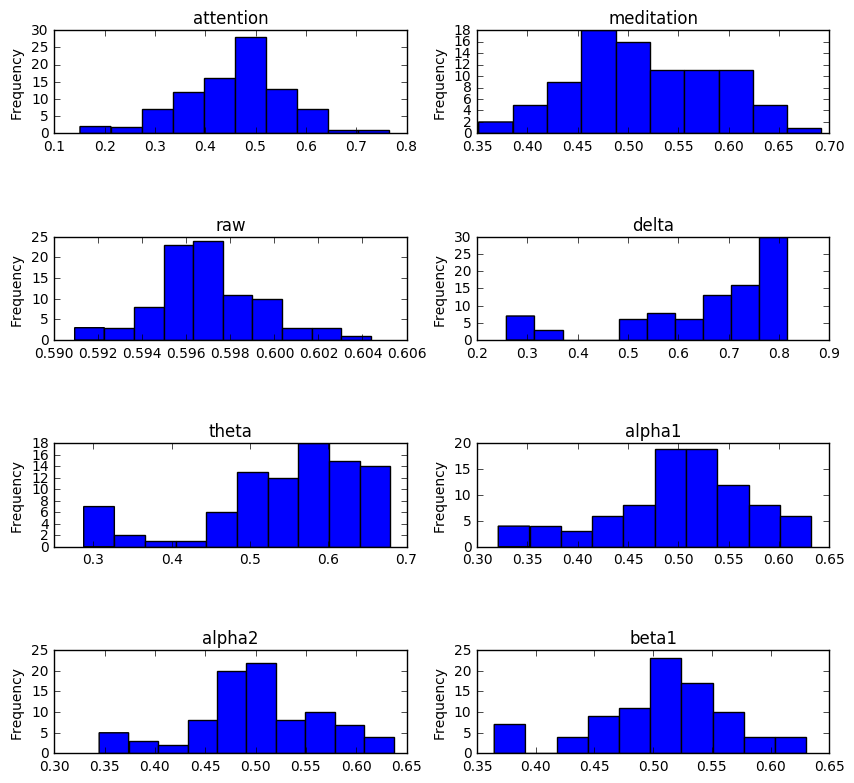

In [61]:
subvid = finaldata.groupby(['subjectid', 'videoid']).mean()

fig = plt.figure(figsize = (10, 20))
fig.subplots_adjust(hspace=1.0)

plt.subplot(821)
subvid['attention'].plot(kind = 'hist')
plt.title('attention')

plt.subplot(822)
subvid['meditation'].plot(kind = 'hist')
plt.title('meditation')

plt.subplot(823)
subvid['raw'].plot(kind = 'hist')
plt.title('raw')

plt.subplot(824)
subvid['delta'].plot(kind = 'hist')
plt.title('delta')

plt.subplot(825)
subvid['theta'].plot(kind = 'hist')
plt.title('theta')

plt.subplot(826)
subvid['alpha1'].plot(kind = 'hist')
plt.title('alpha1')

plt.subplot(827)
subvid['alpha2'].plot(kind = 'hist')
plt.title('alpha2')

plt.subplot(828)
subvid['beta1'].plot(kind = 'hist')
plt.title('beta1')


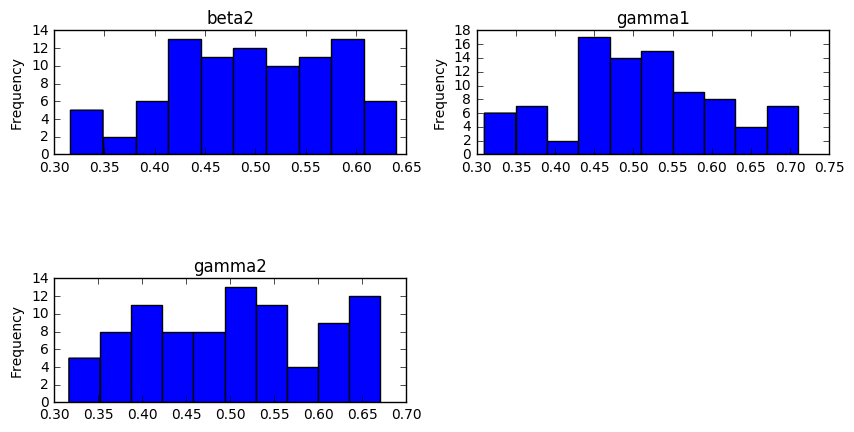

In [62]:
fig = plt.figure(figsize = (10, 8))
fig.subplots_adjust(hspace=1.0)

plt.subplot(321)
subvid['beta2'].plot(kind = 'hist')
plt.title('beta2')

plt.subplot(322)
subvid['gamma1'].plot(kind = 'hist')
plt.title('gamma1')

plt.subplot(323)
subvid['gamma2'].plot(kind = 'hist')
plt.title('gamma2')